In [1]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import Normalizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoModel, AutoTokenizer, GPT2Config
import torch
import transformers
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import datetime
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import LogitsProcessor, LogitsProcessorList
import ast

# template = """Answer the question based on the context below. Keep the answer short.

# Context: {context}
# Question: {question}
# Answer:"""

# template = """{context}
# {question}
# Answer:"""

# template = """Answer the question based on the context below. Keep the answer short.

# Context: {context}"""

template = """{context}"""

/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
class ConstrainedPrefixLogitsProcessor(LogitsProcessor):
    def __init__(self, allowed_seqs, tokenizer):
        self.tokenizer = tokenizer
        # Add a space at the start of each sequence
        self.allowed_seqs = [f" {seq}" for seq in allowed_seqs]
        # Add period to the allowed sequences
        self.allowed_seqs.append('.')
        self.allowed_seqs.append('<|end_of_text|>')

        self.allowed_token_seqs = [tokenizer(seq, add_special_tokens=False)['input_ids'] for seq in self.allowed_seqs]
        # Add end of sentence token to the allowed sequences
        self.allowed_token_seqs.append([tokenizer.eos_token_id])
         
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        batch_size, vocab_size = scores.shape
        current_len = input_ids.shape[-1]
        
        allowed_next_tokens = set()
        for seq in self.allowed_token_seqs:
            if len(seq) > current_len:
                if torch.equal(input_ids[0][-len(seq)+1:], torch.tensor(seq[:-1], device=input_ids.device)):
                    allowed_next_tokens.add(seq[len(input_ids[0]) - len(seq)])

        if not allowed_next_tokens:
            # Start of generation, allow first tokens of all candidate sequences
            allowed_next_tokens = {seq[0] for seq in self.allowed_token_seqs}

        mask = torch.full_like(scores, float("-inf"))
        for token_id in allowed_next_tokens:
            mask[0, token_id] = scores[0, token_id]
        return mask


import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform
from scipy.linalg import eigh

class LinearMetricEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, graph='trivial'):
        """
        Parameters:
            n_components: int
                Target embedding dimension.
            graph: str or callable
                If 'trivial', d_ij = 0 if y_i == y_j else 1.
                If callable, should return a (n x n) ideal distance matrix given y.
        """
        self.n_components = n_components
        self.graph = graph
        self.W_ = None

    def _compute_ideal_distances(self, y):
        n = len(y)
        d_ij = np.zeros((n, n))

        if self.graph == 'trivial':
            for i in range(n):
                for j in range(n):
                    d_ij[i, j] = 0.0 if y[i] == y[j] else 1.0
        elif self.graph == 'euclidean':
            for i in range(n):
                for j in range(n):
                    d_ij[i, j] = np.linalg.norm(y[i] - y[j])
        elif self.graph == 'circular':
            max_y = np.max(y)
            for i in range(n):
                for j in range(n):
                    d_ij[i, j] = min(np.abs(y[i] - y[j]), max_y + 1 - np.abs(y[i] - y[j]))

        elif callable(self.graph):
            d_ij = self.graph(y)
        else:
            raise ValueError("Invalid graph specification.")
        
        return d_ij

    def _classical_mds(self, D):
        # Step 1: square distances
        D2 = D ** 2

        # Step 2: double centering
        n = D2.shape[0]
        H = np.eye(n) - np.ones((n, n)) / n
        B = -0.5 * H @ D2 @ H

        # Step 3: eigen-decomposition
        eigvals, eigvecs = eigh(B)
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx][:self.n_components]
        eigvecs = eigvecs[:, idx][:, :self.n_components]

        # Step 4: compute embedding
        Y = eigvecs * np.sqrt(np.maximum(eigvals, 0))
        return Y

    def fit(self, X, y):
        """
        Fit the linear transformation W to match distances induced by labels y.
        """
        X = np.asarray(X)
        D = self._compute_ideal_distances(y)
        Y = self._classical_mds(D)

        # Solve W in least squares: Y ≈ WX
        X_centered = X - X.mean(axis=0)
        Y_centered = Y - Y.mean(axis=0)

        # Use pseudo-inverse
        self.W_ = Y_centered.T @ np.linalg.pinv(X_centered.T)
        return self

    def transform(self, X):
        """
        Apply the learned transformation to X.
        """
        if self.W_ is None:
            raise RuntimeError("You must fit the model before calling transform.")
        X = np.asarray(X)
        X_centered = X - X.mean(axis=0)  # Important: center using same logic as during fit
        return (self.W_ @ X_centered.T).T

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)


def format_time(time):
    if time.hour == 0:
        return f"{time.strftime('%I:%M%p').lower()}"
    elif time.hour == 12:
        return f"{time.strftime('%I:%M%p').lower()}"
    else:
        if time.minute == 0:
            return f"{time.strftime('%-I%p').lower()}"
        else:
            return f"{time.strftime('%-I:%M%p').lower()}"

def clean(x):
    return ast.literal_eval(x)

def compute_activations(df, model, tokenizer, idx_column='date_idx_end', question_column='question', answer_column='correct', context_column='context', target_content=None):
    model.eval()
    outputs = []
    for _, row in tqdm(df.iterrows()):
        context = row[context_column] if context_column in row else row['sentence']
        question = row[question_column] if question_column in row else None
        answer = row[answer_column] if answer_column in row else None
        sentence = template.format(context=context, question=question, answer=answer)

        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")
        if target_content is not None:
            # Find the index of the target content in the sentence
            content = row[target_content] if target_content in row else None
            idx_end = sentence.find(content)
            if idx_end == -1:
                raise ValueError(f"Content '{content}' not found in the sentence.")
            idx_end = idx_end + len(content)
            idx_end = len(tokenizer(sentence[:idx_end])['input_ids']) - 1
            
        elif idx_column is not None:
            idx_end = row[idx_column]

            # idx_end might be shifted if the formatted context is later in the sentence
            # find the context in the sentence, compute the new idx_end
            idx_end = sentence.find(context) + idx_end

            idx_end = len(tokenizer(sentence[:idx_end])['input_ids']) - 1
        else:
            idx_end = -1

        hidden_states = model(**input_ids, output_hidden_states=True).hidden_states
        hidden_states = [h.type(torch.float16) for h in hidden_states]
        hidden_states = torch.concat(hidden_states, dim=0).cpu().detach().numpy()[:,idx_end,:]
        outputs.append(hidden_states)
    return np.stack(outputs, axis=1)

def eval_dataset(df, model, tokenizer, question_column='question', answer_column='correct', context_column='context'):
    model.eval()
    correct = []
    with tqdm(df.iterrows(), total=len(df)) as pbar:
        for _, row in pbar:
            context = row[context_column] if context_column in row else row['sentence']
            question = row[question_column] if question_column in row else None
            # answer = row[answer_column] if answer_column in row else None
            sentence = template.format(context=context, question=question, answer='')

            input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")

            # Generate the answer to the question, no sampling
            outputs = model.generate(**input_ids, max_new_tokens=8)
            # Decode the generated answer. Keep only answer and not entire prompt
            answer = tokenizer.decode(outputs[0][len(input_ids['input_ids'][0]):], skip_special_tokens=True)
            # Check if the generated answer is correct
            if row[answer_column] in answer:
                correct.append(1)
            else:
                correct.append(0)
            # print(f"Running mean: {np.array(correct).mean()} Generation: {answer} Correct: {row[answer_column]}")
            # Display running mean in tqdm
            pbar.set_postfix({'Running mean': np.array(correct).mean()})

    return np.array(correct), np.array(correct).mean()

# Does both the evaluation and storing of activations
def activate_eval(df, model, tokenizer, question_column='question', answer_column='correct', context_column='context', 
                  target_column=None, bypass_eval=False, constrained_generation=False, delta_token=None):
    model.eval()
    outputs = []
    filtered_df = []
    logits_processor = None
        
    for _, row in tqdm(df.iterrows(), total=len(df)):
        context = row[context_column] if context_column in row else row['sentence']
        question = row[question_column] if question_column in row else None
        answer = str(row[answer_column]) if answer_column in row else None
        sentence = template.format(context=context, question=question, answer=answer)

        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")

        if constrained_generation:
            if 'alternatives' not in row:
                raise ValueError("Alternatives column not found in dataset.")
            logits_processor = LogitsProcessorList()
            logits_processor.append(ConstrainedPrefixLogitsProcessor(
                allowed_seqs=row['alternatives'],
                tokenizer=tokenizer
            ))

        # Generate the answer to the question, no sampling
        # NOTE: generate only outputs the hidden states of the generation, not the input
        generations = model.generate(**input_ids, max_new_tokens=8, return_dict_in_generate=True, output_hidden_states=True, 
                                     do_sample=False, logits_processor=logits_processor)
        # Decode the generated answer. Keep only answer and not entire prompt
        decoded = tokenizer.decode(generations.sequences[0][len(input_ids['input_ids'][0]):], skip_special_tokens=True)

        # Check if the generated answer is correct
        answer_idx = decoded.find(answer)
        if answer_idx == -1 and not bypass_eval:
            continue  

        if target_column is None:
            # generate() outputs a set of hidden states for each generated token
            # we first need to find the corresponding generation index in the generated text using answer_idx
            gen_idx = answer_idx + len(answer)
            gen_idx = len(tokenizer(decoded[:gen_idx])['input_ids']) - 1
            target_idx = len(input_ids['input_ids'][0]) - 1 + gen_idx
            if delta_token: # Get a shifted token
                target_idx = target_idx + delta_token
        else: # Find the last token of the target content
            # Find the index of the target content in the sentence
            content = row[target_column] if target_column in row else None
            idx_end = sentence.find(content)
            if idx_end == -1:
                raise ValueError(f"Content '{content}' not found in the sentence.")
            idx_end = idx_end + len(content)
            idx_end = len(tokenizer(sentence[:idx_end])['input_ids'])
            target_idx = idx_end

        # NOTE: the first element of hidden_states is the input embedding, it has word size n_prompt_tokens
        # and the rest are the hidden states of the generated tokens each with size 1
        # We can stack them as (n_layers, tokens, hidden_dim)
        # the full length of tokens is = prompt size + n_generated_tokens - 1
        hidden_states = torch.cat([torch.cat(hs, dim=0) for hs in generations.hidden_states], dim=1)
        hidden_states = hidden_states.type(torch.float64)
        try:
            hidden_states = hidden_states[:, target_idx]
        except IndexError:
            print(f"IndexError: {gen_idx} out of range for {target_idx}")
            continue
        hidden_states = hidden_states.cpu().detach().numpy()

        # hidden_states = generations.hidden_states[gen_idx]
        # hidden_states = [h.type(torch.float16)[0,idx_end,:] for h in hidden_states]


        outputs.append(hidden_states)
        filtered_df.append(row)

    filtered_df = pd.DataFrame(filtered_df)
    print(f"Model accuracy: {len(filtered_df)/len(df)}")
    return np.stack(outputs, axis=1), filtered_df

### Models

Run one of the following cells to set which model to probe

In [3]:
from transformers import LlamaConfig, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = LlamaConfig.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


In [ ]:
config = GPT2Config.from_pretrained("gpt2", output_hidden_states=True)
model = AutoModel.from_pretrained("gpt2", config=config)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model.to("cuda")

In [ ]:
from transformers import Gemma2Config, AutoModelForCausalLM, AutoTokenizer

config = GPT2Config.from_pretrained("gpt2", output_hidden_states=True)
model = AutoModelForCausalLM.from_pretrained("gpt2", config=config)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model.to("cuda")

In [ ]:
from transformers import Gemma2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Gemma2Config.from_pretrained("google/gemma-2-2b-it")
model = AutoModel.from_pretrained(
    "google/gemma-2-2b-it",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


In [3]:
from transformers import Gemma2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Gemma2Config.from_pretrained("google/gemma-2-2b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


In [ ]:
from transformers import Gemma2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Gemma2Config.from_pretrained("google/gemma-2-2b")
model = AutoModel.from_pretrained(
    "google/gemma-2-2b",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
model.to("cuda")

In [ ]:
from transformers import Gemma2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Gemma2Config.from_pretrained("google/gemma-2-2b")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
model.to("cuda")

In [5]:
from transformers import Qwen2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Qwen2Config.from_pretrained("Qwen/Qwen2-0.5B-Instruct")
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-0.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")


In [ ]:
from transformers import Qwen2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Qwen2Config.from_pretrained("Qwen/Qwen2-0.5B")
model = AutoModel.from_pretrained(
    "Qwen/Qwen2-0.5B",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B")

### Activations

Run one of the following cells to set which dataset to compute the activations on

In [16]:
# Run model on absolute relative sentences (tagged for dates and verbs)

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/absolute_ordered_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['datetime'] = pd.to_datetime(df['datetime'])
df['label'] = df['datetime'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))


# Create train and test sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]
test_set = df

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer, context_column='sentence')
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer, context_column='sentence')
activations_test = compute_activations(test_set, model=model, tokenizer=tokenizer, context_column='sentence')

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']


0it [00:00, ?it/s]

752it [00:04, 170.21it/s]
188it [00:01, 172.65it/s]
940it [00:05, 169.28it/s]


In [ ]:
# Run model on relative relative sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/relative_ordered_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['label'] = df['hours_delta']
# Perform absolute value and log scaling
df['label'] = df['label'].apply(lambda x: np.log(np.abs(x)+1))
# Normalize min and max
min_hours = df['label'].min()
max_hours = df['label'].max()
df['label'] = df['label'].apply(lambda x: (x-min_hours)/(max_hours-min_hours))
# Print min and max to check if normalization is correct
# print(df['label'].min(), df['label'].max())

df['class'] = df['reference_type']

# Create train and test sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]
test_set = df

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer)
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer)
activations_test = compute_activations(test_set, model=model, tokenizer=tokenizer)

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

400it [00:18, 22.02it/s]
100it [00:04, 21.23it/s]
500it [00:22, 21.94it/s]


In [19]:
# Run model on reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer, idx_column=None, target_content='correct')
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer, idx_column=None, target_content='correct')
activations_test = compute_activations(df, model=model, tokenizer=tokenizer, idx_column=None, target_content='correct')

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = df['label']

# activations_train_date = eval_df(train_set, idx_column='date_idx_end')
# activations_test_date = eval_df(test_set, idx_column='date_idx_end')
# activations_train_answer = eval_df(train_set, idx_column=None)
# activations_test_answer = eval_df(test_set, idx_column=None)


# activations_train = activations_train_date
# activations_test = activations_test_date

# all_activations = np.concatenate([activations_train_answer, activations_test_answer], axis=1)
# # all_activations = np.concatenate([activations_train, activations_test], axis=1)
# all_labels = df['label']

0it [00:00, ?it/s]

600it [00:03, 167.33it/s]
150it [00:00, 169.42it/s]
750it [00:04, 168.20it/s]


In [22]:
# Run model on numerical reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences_num.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
df['correct'] = df['correct'].astype(str)

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]
test_set = df

activations_train = compute_activations(train_set, model=model, tokenizer=tokenizer, idx_column='date_idx_end', question_column='question_num')
activations_dev = compute_activations(dev_set, model=model, tokenizer=tokenizer, idx_column='date_idx_end', question_column='question_num')
activations_test = compute_activations(test_set, model=model, tokenizer=tokenizer, idx_column=None, question_column='question_num')


labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

600it [00:03, 167.43it/s]
150it [00:00, 168.91it/s]
750it [00:04, 171.49it/s]


In [ ]:
# Eval model performance on reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
df['correct'] = df['correct'].astype(str)

# Create train and dev sets
split = 0.8
test_set = df

generations, accuracy = eval_dataset(test_set, model=model, tokenizer=tokenizer, question_column='question')

print("Accuracy: ", accuracy)

In [ ]:
# Eval model performance on numerical reasoning sentences

transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences_num.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
df['correct'] = df['correct'].astype(str)

# Create train and dev sets
split = 0.8
test_set = df

generations, accuracy = eval_dataset(test_set, model=model, tokenizer=tokenizer, question_column='question_num')

print("Accuracy: ", accuracy)

In [ ]:
# Eval/activate model on date reasoning sentences
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_sentences_3way_season.csv',
                 converters={'alternatives': clean})
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train, train_set = activate_eval(train_set, model=model, tokenizer=tokenizer, constrained_generation=True) #, target_column='time_str')
activations_dev, dev_set = activate_eval(dev_set, model=model, tokenizer=tokenizer, constrained_generation=True) #, target_column='time_str')
# activations_test, test_set = activate_eval(df, model=model, tokenizer=tokenizer)
# Get test set by combining train and dev sets
activations_test = np.concatenate([activations_train, activations_dev], axis=1)
test_set = pd.concat([train_set, dev_set], axis=0)

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

In [ ]:
# Eval/activate model on duration reasoning sentences
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/duration_reasoning_3way_1hop.csv',
                 converters={'alternatives': clean})
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_date'] = pd.to_datetime(df['correct_date'])
df['label'] = df['correct_date'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train, train_set = activate_eval(train_set, model=model, tokenizer=tokenizer, delta_token=-1) #, bypass_eval=True, target_column='correct_date_expr')
activations_dev, dev_set = activate_eval(dev_set, model=model, tokenizer=tokenizer, delta_token=-1) #, bypass_eval=True, target_column='correct_date_expr')
# activations_test, test_set = activate_eval(df, model=model, tokenizer=tokenizer)
# Get test set by combining train and dev sets
activations_test = np.concatenate([activations_train, activations_dev], axis=1)
test_set = pd.concat([train_set, dev_set], axis=0)

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

In [22]:
# Eval/activate model on time of day reasoning sentences
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/reasoning_time_of_day_3way_cyclic.csv',
                 converters={'alternatives': clean})
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['correct_time'] = pd.to_datetime(df['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1))
df['label'] = df['correct_time'].apply(lambda x: x.timestamp())
# Dates go from 12am to 11:59pm
start = datetime.datetime(2019, 1, 1, hour=0, minute=0).timestamp()
end = datetime.datetime(2019, 1, 1, hour=23, minute=59).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))
print(df['label'].min(), df['label'].max())

# Create train and dev sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
dev_set = df.iloc[int(len(df)*split):]

activations_train, train_set = activate_eval(train_set, model=model, tokenizer=tokenizer, delta_token=None)#, constrained_generation=True) #, target_column='time_str')
activations_dev, dev_set = activate_eval(dev_set, model=model, tokenizer=tokenizer, delta_token=None)#, constrained_generation=True) #, target_column='time_str')
# activations_test, test_set = activate_eval(df, model=model, tokenizer=tokenizer)
# Get test set by combining train and dev sets
activations_test = np.concatenate([activations_train, activations_dev], axis=1)
test_set = pd.concat([train_set, dev_set], axis=0)

labels_train = train_set['label']
labels_dev = dev_set['label']
labels_test = test_set['label']

/tmp/ipykernel_41260/1240052790.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['correct_time'] = pd.to_datetime(df['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1))


0.04169562195969423 1.0319666435024322


  0%|          | 0/800 [00:00<?, ?it/s]/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
100%|██████████| 800/800 [02:36<00:00,  5.11it/s]


Model accuracy: 0.33625


  0%|          | 0/200 [00:00<?, ?it/s]/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


Model accuracy: 0.355


In [ ]:
# # Replace labels with something else
# df['label'] = df['correct_time_diff']
# min_label = df['label'].min()
# max_label = df['label'].max()
# df['label'] = df['label'].apply(lambda x: (x-min_label)/(max_label-min_label))

# # NB: this introduces data leakage
# labels_train = train_set['correct_time_diff'].apply(lambda x: (x-min_label)/(max_label-min_label))
# labels_dev = dev_set['correct_time_diff'].apply(lambda x: (x-min_label)/(max_label-min_label))
# labels_test = test_set['correct_time_diff'].apply(lambda x: (x-min_label)/(max_label-min_label))

# Map season labels to numbers 0: winter, 1: spring, 2: summer, 3: fall
# labels_train = train_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()
# labels_dev = dev_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()
# labels_test = test_set['correct_season'].apply(lambda x: 0 if x == 'winter' else (1 if x == 'spring' else (2 if x == 'summer' else 3))).to_numpy()

# Introduce secondary labels
# Finds the start and end of the time range
secondary_start = pd.to_datetime(df['correct_date']).min().timestamp()
secondary_end = pd.to_datetime(df['correct_end_date']).max().timestamp()
secondary_labels_train = pd.to_datetime(train_set['correct_end_date']).apply(lambda x: x.timestamp()).apply(lambda x: np.log(x-secondary_start))
secondary_labels_dev = pd.to_datetime(dev_set['correct_end_date']).apply(lambda x: x.timestamp()).apply(lambda x: np.log(x-secondary_start))
secondary_labels_test = pd.to_datetime(test_set['correct_end_date']).apply(lambda x: x.timestamp()).apply(lambda x: np.log(x-secondary_start))

# secondary_labels_train = train_set['correct_duration_days'].apply(lambda x: np.log(x))
# secondary_labels_dev = dev_set['correct_duration_days'].apply(lambda x: np.log(x))
# secondary_labels_test = test_set['correct_duration_days'].apply(lambda x: np.log(x))

# secondary_labels_train = secondary_labels_train.apply(lambda x: (x-min(secondary_labels_train))/(max(secondary_labels_train)-min(secondary_labels_train)))
# secondary_labels_dev = secondary_labels_dev.apply(lambda x: (x-min(secondary_labels_train))/(max(secondary_labels_train)-min(secondary_labels_train)))
# secondary_labels_test = secondary_labels_test.apply(lambda x: (x-min(secondary_labels_train))/(max(secondary_labels_train)-min(secondary_labels_train)))

# joint_labels_train = pd.DataFrame({'label': labels_train, 'secondary_label': secondary_labels_train})
# joint_labels_dev = pd.DataFrame({'label': labels_dev, 'secondary_label': secondary_labels_dev})
# joint_labels_test = pd.DataFrame({'label': labels_test, 'secondary_label': secondary_labels_test})

# double_labels_test = (labels_test.copy() + secondary_labels_test.copy()) / 2

# df_time = pd.to_datetime(df['time'])
# # df_time = pd.to_datetime(df['correct_time'])
# df_time = df_time.apply(lambda x: x.replace(year=2019, month=1, day=1))
# df_time = df_time.apply(lambda x: x.timestamp())
# # Dates go from 12am to 11:59pm
# start = datetime.datetime(2019, 1, 1, hour=0, minute=0).timestamp()
# end = datetime.datetime(2019, 1, 1, hour=23, minute=59).timestamp()

# labels_train = pd.to_datetime(train_set['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1)).apply(lambda x: x.timestamp()).apply(lambda x: (x-start)/(end-start))
# labels_dev = pd.to_datetime(dev_set['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1)).apply(lambda x: x.timestamp()).apply(lambda x: (x-start)/(end-start))
# labels_test = pd.to_datetime(test_set['correct_time']).apply(lambda x: x.replace(year=2019, month=1, day=1)).apply(lambda x: x.timestamp()).apply(lambda x: (x-start)/(end-start))


### Plotting

Run one of the following cells to plot the activations

Layer 8 score: 0.7898364337656815
Layer 9 score: 0.6768130909785777
Layer 10 score: 0.6317789588367619
Layer 11 score: 0.6527432042524512
Layer 12 score: 0.6719262261490717
Layer 13 score: 0.6003464574224924
Layer 14 score: 0.5408231848923999
Layer 15 score: 0.5957771211073795
Layer 16 score: 0.6801751377061489
Layer 17 score: 0.5956114030178354
Layer 18 score: 0.5958018198815425
Layer 19 score: 0.6049811390220403
Layer 20 score: 0.8847808545052477
Layer 21 score: 0.8759561173251982
Best layer: 20, score: 0.8847808545052477


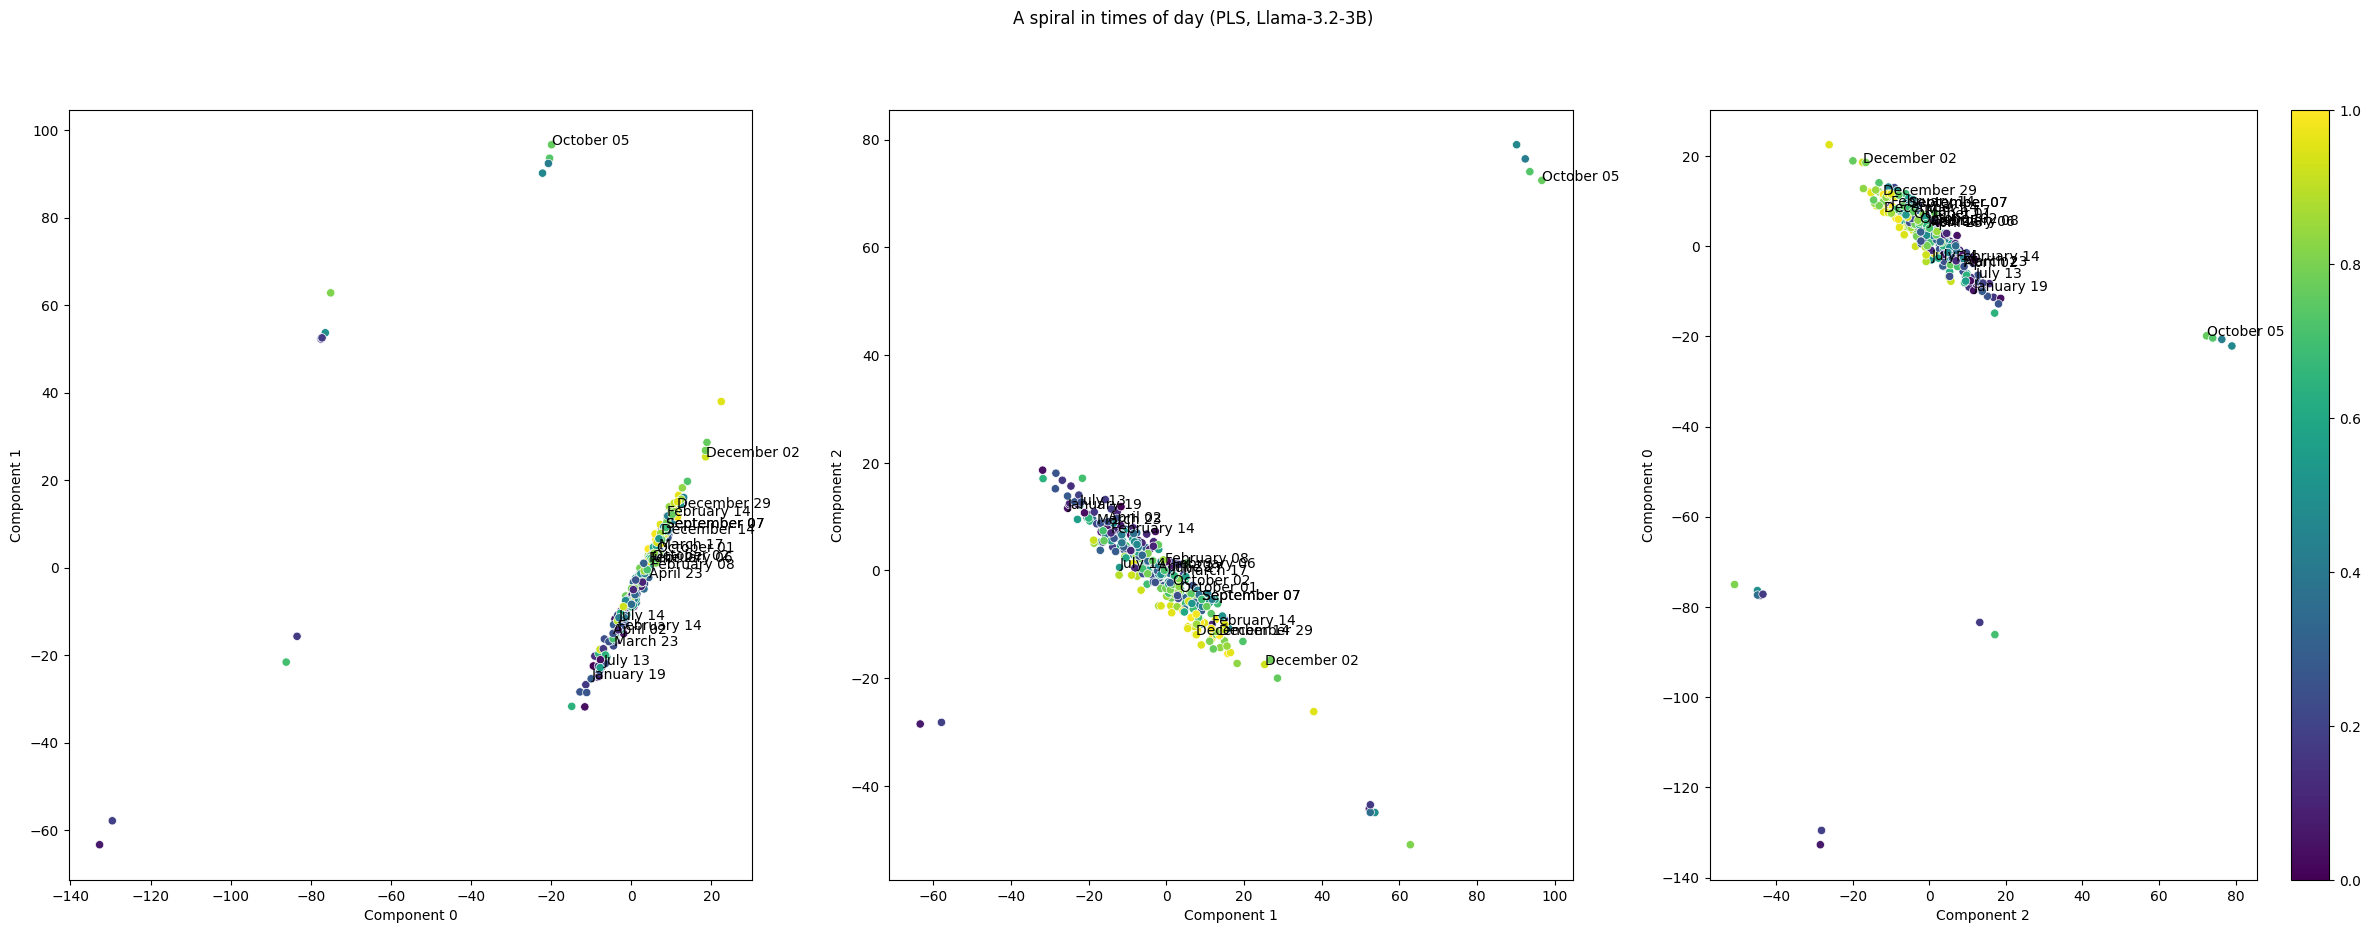

In [ ]:
# PLS regression
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=10)
    pls.fit(layer, labels_train)
    score = pls.score(activations_dev[i], labels_dev)
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 12 # Override best layer


pls = PLSRegression(n_components=3)
# rnd = np.random.randn(*layer.shape)
pls.fit(activations_train[best_layer], labels_train)
# pls.fit(rnd, labels_train)


# pls_train = pls.transform(activations_train[best_layer])
pls_test = pls.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(activations_test[best_layer]), 20)
# Get sentences and acivations
if 'sentence' in test_set.columns:
    rnd_sent = test_set['sentence'].iloc[indices]
elif 'correct_date' in test_set.columns:
    rnd_sent = test_set['correct_date'].iloc[indices]
    # Parse as month day
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%B %d')
elif 'correct_time' in test_set.columns:
    rnd_sent = test_set['correct_time'].iloc[indices]
    # Parse as hour minute
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%H:%M')
rnd_activations = activations_test[best_layer][indices]
# Transform activations
rnd_activations = pls.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    # sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pls_test[:, i%3], y=pls_test[:, (i+1)%3], hue=labels_test, ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('A spiral in times of day (PLS, Llama-3.2-3B)')
plt.show()

In [ ]:
# Double PLS regression on labels and secondary labels on all layers
import matplotlib.patheffects as pe
from pycolormap_2d import ColorMap2DZiegler

best_score = 0
best_layer = 0
transformed_list1 = []
transformed_list2 = []
rnd_activations1 = []
rnd_activations2 = []
indices = np.random.choice(len(activations_test[0]), 15)

for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls1 = PLSRegression(n_components=5)
    pls2 = PLSRegression(n_components=5)
    pls1.fit(layer, labels_train)
    pls2.fit(layer, secondary_labels_train)
    score1 = pls1.score(activations_dev[i], labels_dev)
    score2 = pls2.score(activations_dev[i], secondary_labels_dev)
    score = (score1 + score2) / 2
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i

    transformed_test1 = pls1.transform(activations_test[i])
    transformed_test2 = pls2.transform(activations_test[i])

    transformed_list1.append(transformed_test1)
    transformed_list2.append(transformed_test2)

    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(pd.to_datetime(x['correct_end_date']).strftime('%d/%m')), axis=1)
    rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(x['correct_duration_str']), axis=1)
    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['context']), axis=1)
    rnd_activations1.append(transformed_test1[indices])
    rnd_activations2.append(transformed_test2[indices])


print(f'Best layer: {best_layer}, score: {best_score}')


# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_list1)/4)), 4, figsize=(30, 30))

norm_labels1 = (labels_test - labels_test.min()) / (labels_test.max() - labels_test.min())
norm_labels2 = (secondary_labels_test - secondary_labels_test.min()) / (secondary_labels_test.max() - secondary_labels_test.min())

cmap = ColorMap2DZiegler()
hues = [cmap(l1,l2) / 255.0 for l1, l2 in zip(norm_labels1, norm_labels2)]

for i in range(len(transformed_list1)):
    # sns.scatterplot(x=transformed_list1[i][:, 0], y=transformed_list2[i][:, 0], hue=hues, ax=axs[i//4][i%4], palette='viridis')
    axs[i//4][i%4].scatter(transformed_list1[i][:, 0], transformed_list2[i][:, 0], color=hues)
    # axs[i//4][i%4].get_legend().set_visible(False)

    # Set max and min for x and y axes to 0.5
    axs[i//4][i%4].set_xlim(-20, 20)
    axs[i//4][i%4].set_ylim(-25, 25)

    # Annotate a few points only if they fall in the range
    for j, txt in enumerate(rnd_sent):
        if rnd_activations1[i][j, 0] < axs[i//4][i%4].get_xlim()[1] and rnd_activations1[i][j, 0] > axs[i//4][i%4].get_xlim()[0] and rnd_activations2[i][j, 0] < axs[i//4][i%4].get_ylim()[1] and rnd_activations2[i][j, 0] > axs[i//4][i%4].get_ylim()[0]:
            # axs[i//4][i%4].annotate(txt, (rnd_activations1[i][j, 0], rnd_activations2[i][j, 0]))
            axs[i//4][i%4].text(rnd_activations1[i][j, 0], rnd_activations2[i][j, 0], txt, path_effects=[pe.withStroke(linewidth=2, foreground="white")])


# Set title
plt.suptitle('Two-dimensional linear features (PLS)', fontsize=16)
plt.show()

In [ ]:
# 2D PLS regression on double labels on all layers
import matplotlib.patheffects as pe
from pycolormap_2d import ColorMap2DZiegler

best_score = 0
best_layer = 0
transformed_list = []
rnd_activations = []
indices = np.random.choice(len(activations_test[0]), 15)

for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=5)
    pls.fit(layer, joint_labels_train.to_numpy())
    score = pls.score(activations_dev[i], joint_labels_dev.to_numpy())
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i

    transformed_test = pls.transform(activations_test[i])

    transformed_list.append(transformed_test)

    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(pd.to_datetime(x['correct_end_date']).strftime('%d/%m')), axis=1)
    rnd_sent = test_set.iloc[indices].apply(lambda x: str(pd.to_datetime(x['correct_date']).strftime('%d/%m')) + " " + str(x['correct_duration_str']), axis=1)
    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['context']), axis=1)
    rnd_activations.append(transformed_test[indices])


print(f'Best layer: {best_layer}, score: {best_score}')


# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_list)/4)), 4, figsize=(30, 30))

# norm_labels1 = (labels_test - labels_test.min()) / (labels_test.max() - labels_test.min())
# norm_labels2 = (secondary_labels_test - secondary_labels_test.min()) / (secondary_labels_test.max() - secondary_labels_test.min())

norm_labels = (joint_labels_test - joint_labels_test.min()) / (joint_labels_test.max() - joint_labels_test.min())

cmap = ColorMap2DZiegler()
hues = [cmap(l1,l2) / 255.0 for l1, l2 in norm_labels.to_numpy()]

for i in range(len(transformed_list)):
    # sns.scatterplot(x=transformed_list1[i][:, 0], y=transformed_list2[i][:, 0], hue=hues, ax=axs[i//4][i%4], palette='viridis')
    axs[i//4][i%4].scatter(transformed_list[i][:, 0], transformed_list[i][:, 1], color=hues)
    # axs[i//4][i%4].get_legend().set_visible(False)

    # Annotate a few points
    for j, txt in enumerate(rnd_sent):
        # axs[i//4][i%4].annotate(txt, (rnd_activations1[i][j, 0], rnd_activations2[i][j, 0]))
        axs[i//4][i%4].text(rnd_activations[i][j, 0], rnd_activations[i][j, 1], txt, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    # Set max and min for x and y axes to 0.5
    # axs[i//4][i%4].set_xlim(-20, 20)
    # axs[i//4][i%4].set_ylim(-20, 20)

# Set title
plt.suptitle('Two-dimensional linear features (PLS)', fontsize=16)
plt.show()

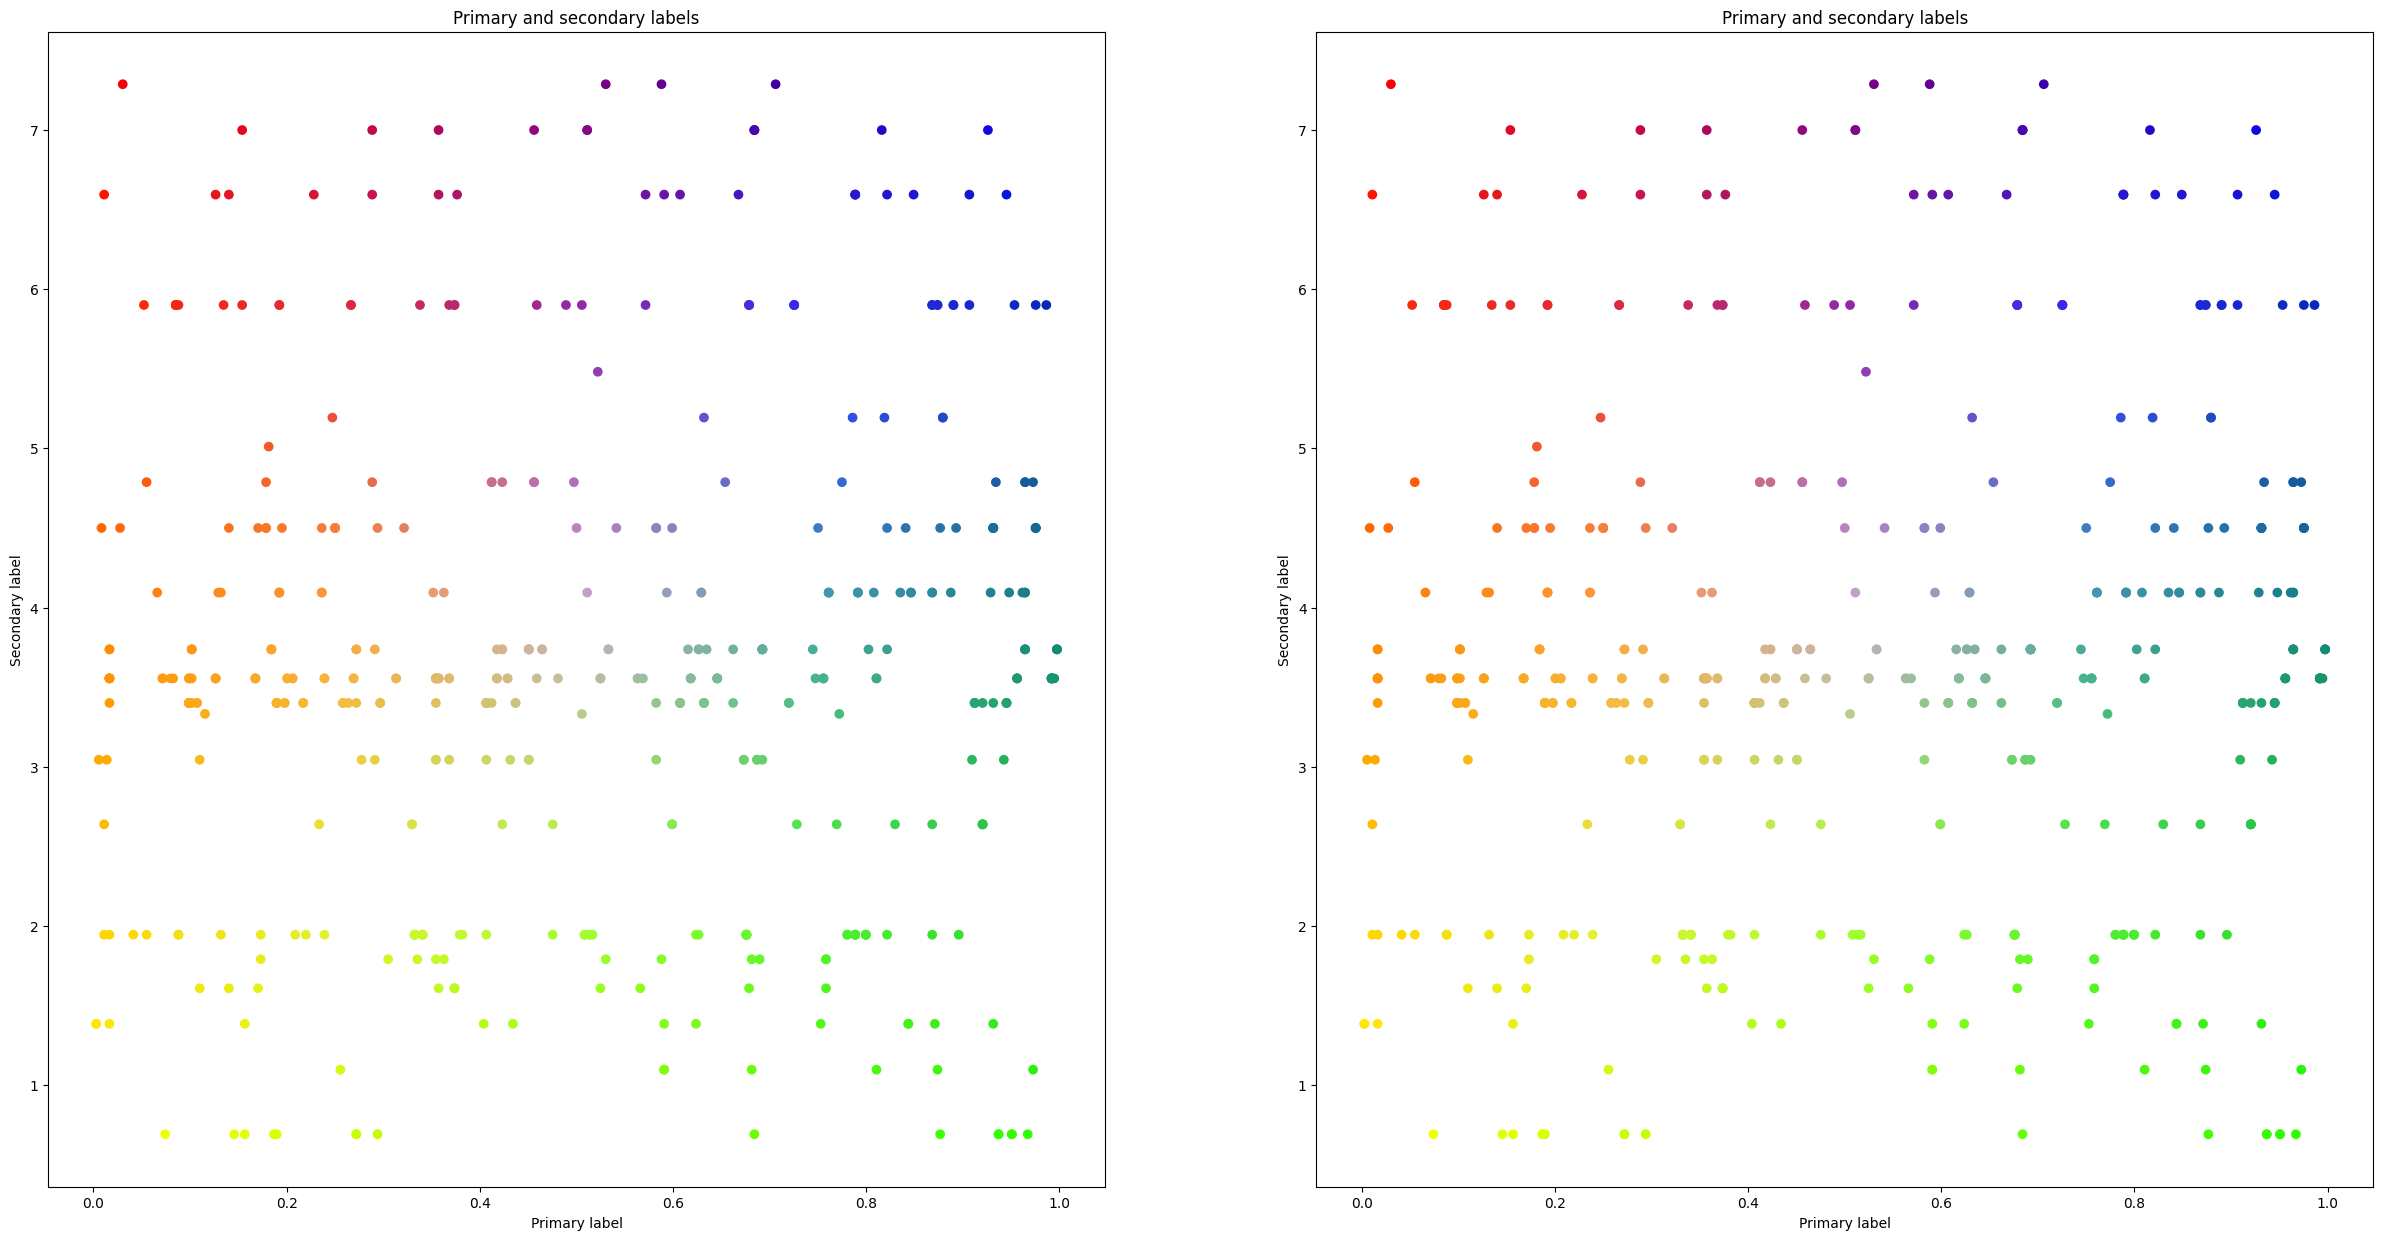

In [75]:
# Plot directly primary and secondary labels
# Make two plots side by side, one with hue primary labels and one with hue secondary labels
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
# sns.scatterplot(x=labels_test, y=secondary_labels_test, hue=labels_test, ax=axs[0], palette='viridis')
axs[0].scatter(labels_test, secondary_labels_test, color=hues)
axs[0].set_xlabel('Primary label')
axs[0].set_ylabel('Secondary label')
axs[0].set_title('Primary and secondary labels')

# sns.scatterplot(x=labels_test, y=secondary_labels_test, hue, ax=axs[1], palette='viridis')
axs[1].scatter(labels_test, secondary_labels_test, color=hues)
axs[1].set_xlabel('Primary label')
axs[1].set_ylabel('Secondary label')
axs[1].set_title('Primary and secondary labels')

plt.show()

In [ ]:
# PCA with a continuous label

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    nm = Normalizer()
    pca = PCA(n_components=3)
    nm.fit(layer)
    pca.fit(nm.transform(layer))
    transformed_train = pca.transform(nm.transform(layer))
    transformed_dev = pca.transform(nm.transform(activations_dev[i]))
    score = np.corrcoef(transformed_dev[:, 0], labels_dev)[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 16 # Override best layer

pca = PCA(n_components=3)
nm = Normalizer()
# nm.fit(activations_train[best_layer])
pca.fit(activations_train[best_layer])

pca_test = pca.transform(nm.transform(activations_test[best_layer]))

# Generate 10 indices
indices = np.random.choice(len(activations_test[best_layer]), 10)
# Get sentences and activations
if 'context' in df.columns:
    # Concatenate context and correct columns
    rnd_sent = df['context'].iloc[indices] + " " + df['correct'].iloc[indices]

elif 'sentence' in df.columns:
    rnd_sent = df['sentence'].iloc[indices]
else:
    raise ValueError('No sentence column found in dataframe')
rnd_activations = activations_test[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(nm.transform(rnd_activations))

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    # sns.scatterplot(x=pca_train[:, i % 3], y=pca_train[:, (i + 1) % 3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pca_test[:, i % 3], y=pca_test[:, (i + 1) % 3], hue=labels_test, ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')
    ax.get_legend().set_visible(False)

fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

Layer 0 score: 0.1894834265155382
Layer 1 score: -0.16379073599082042
Layer 2 score: -0.16552422985241622
Layer 3 score: -0.16130349567668945
Layer 4 score: -0.15498893565832922
Layer 5 score: -0.157812326696122
Layer 6 score: 0.15802766807302646
Layer 7 score: 0.16483202648542514
Layer 8 score: 0.16516507353771068
Layer 9 score: 0.16623851697927225
Layer 10 score: 0.17275308164918682
Layer 11 score: 0.17238668923192943
Layer 12 score: 0.17293278708500268
Layer 13 score: 0.17293110121970084
Layer 14 score: 0.17159619931642053
Layer 15 score: 0.16744977551511503
Layer 16 score: -0.17069337490093683
Layer 17 score: 0.17412851401399576
Layer 18 score: 0.1705986400161059
Layer 19 score: 0.1703457751036863
Layer 20 score: 0.17402071688344703
Layer 21 score: 0.17582259587751575
Layer 22 score: 0.17755220891494947
Layer 23 score: 0.17696225822587006
Layer 24 score: 0.17696863007868846
Layer 25 score: 0.17002606374497897
Layer 26 score: 0.17231517378977124
Layer 27 score: 0.1686140681451669
La

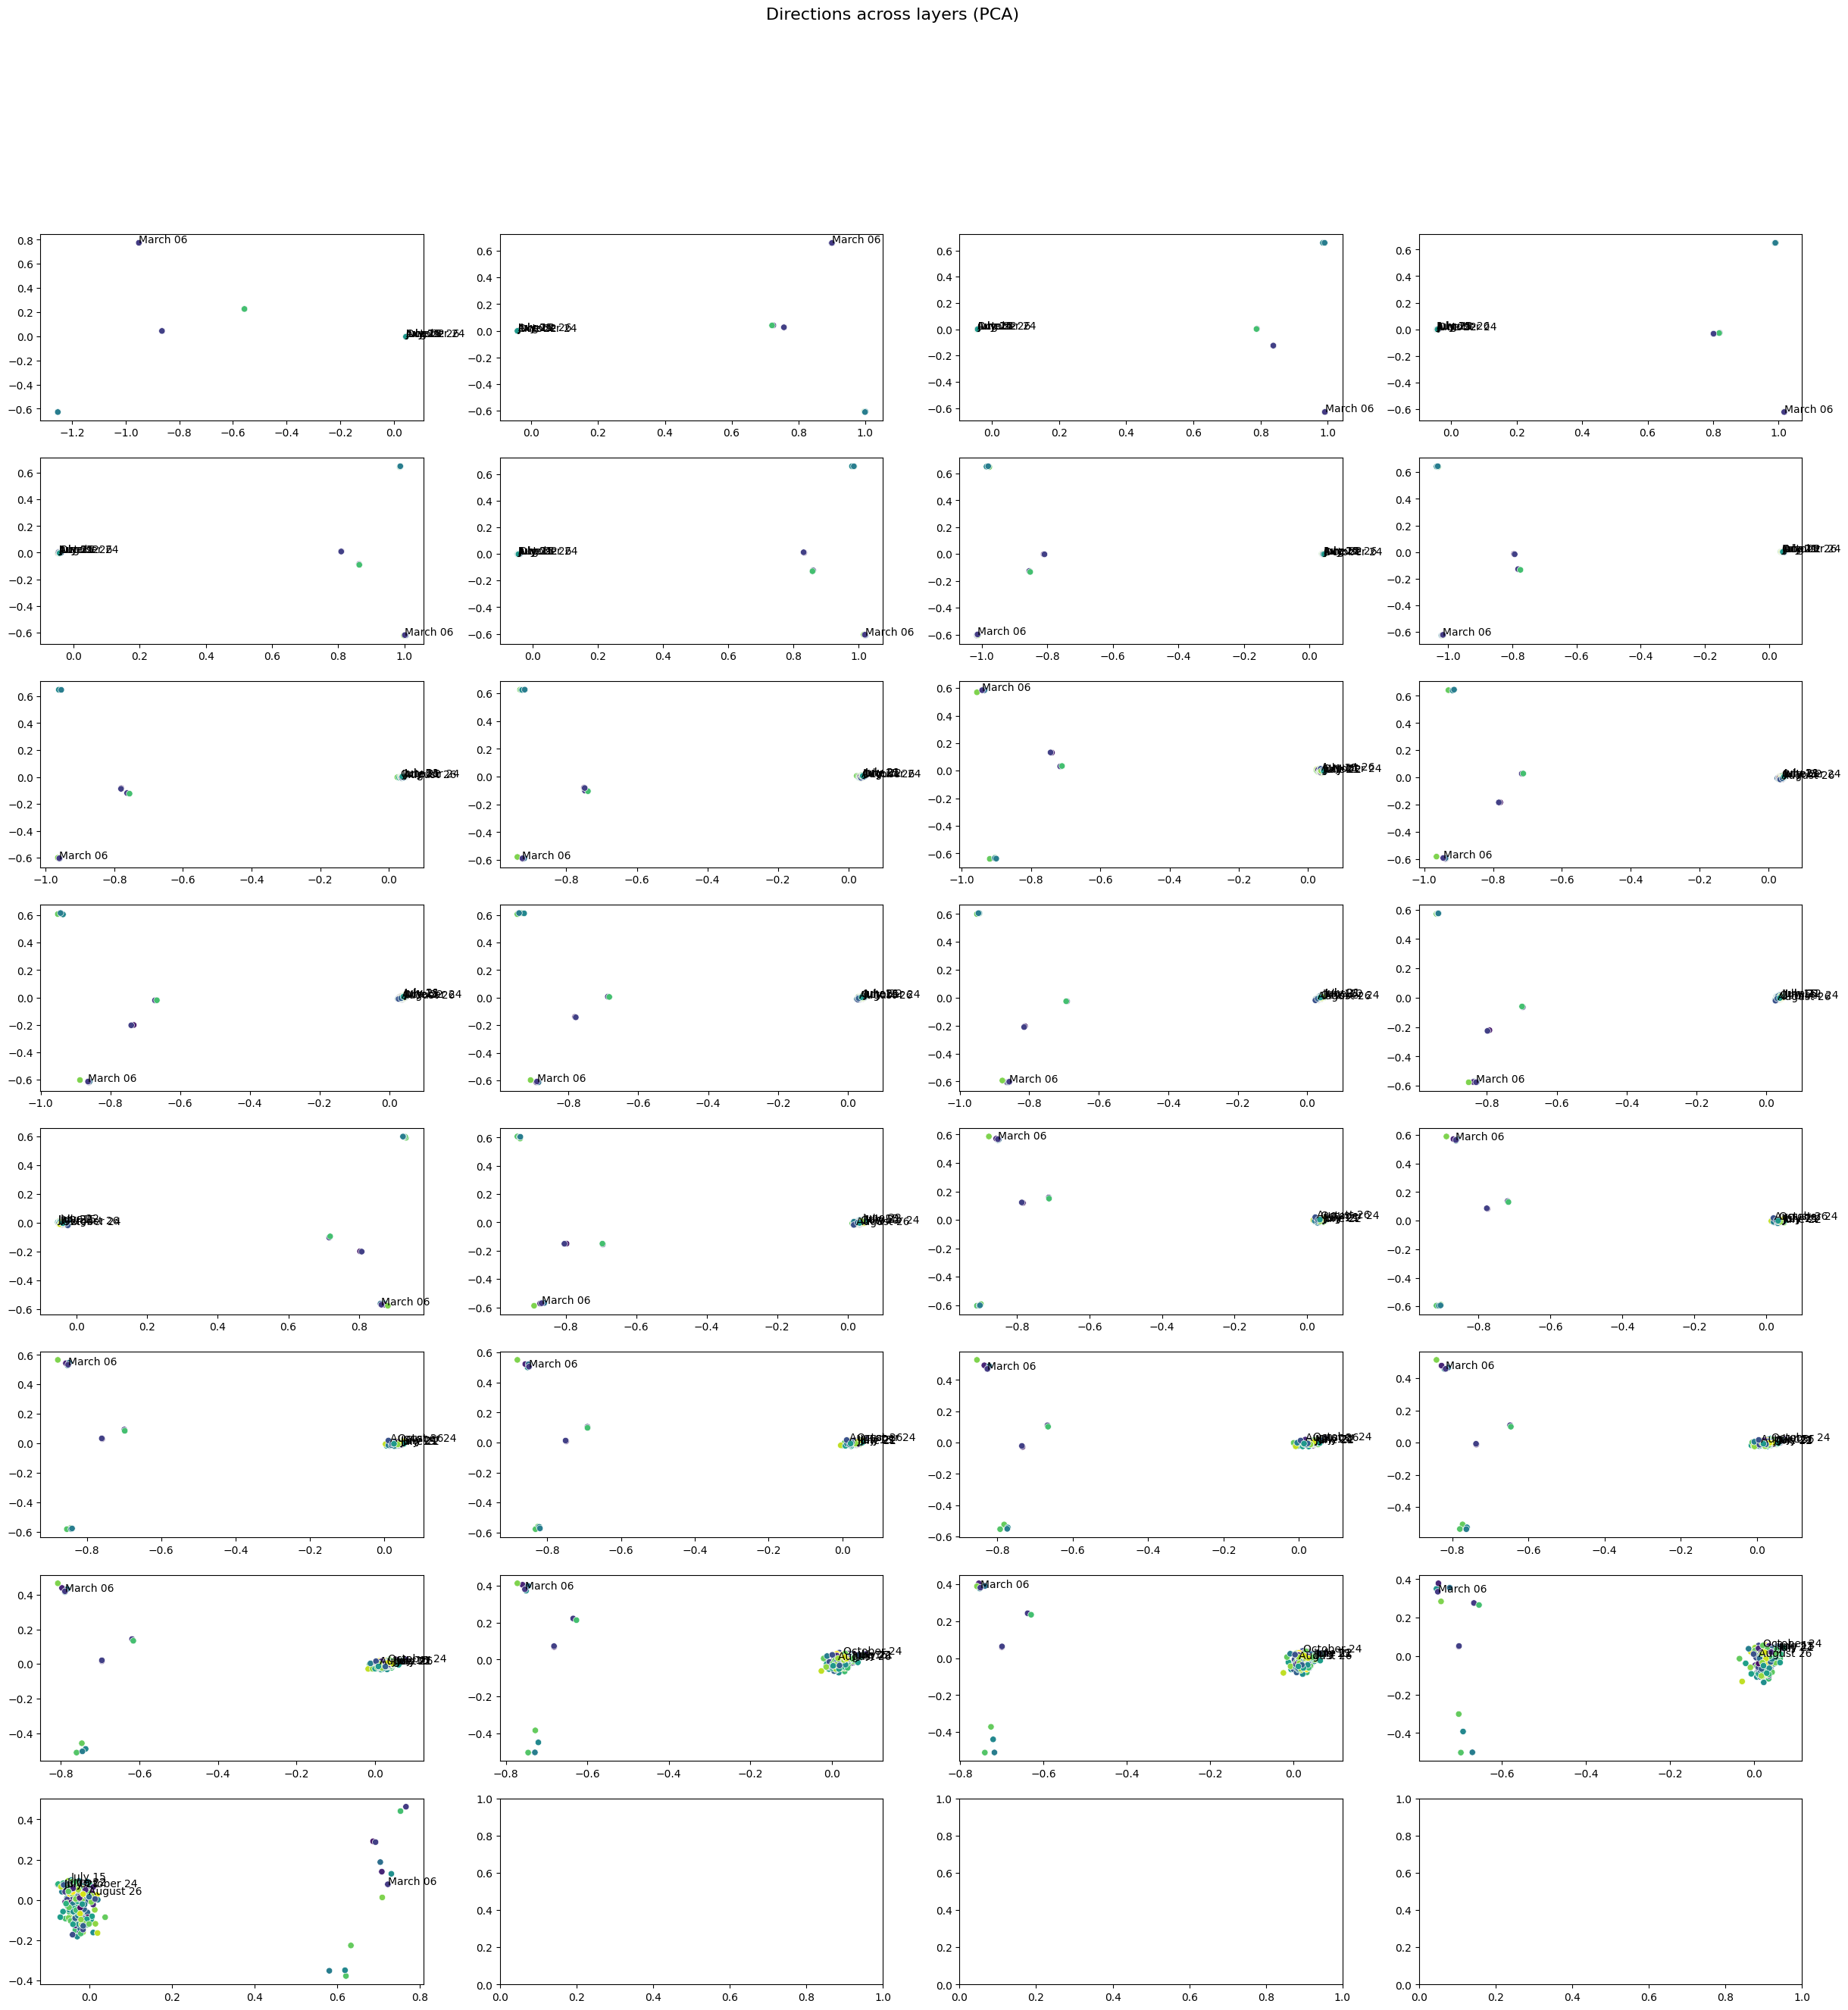

In [186]:
# PCA with a continuous label on all layers
component1 = 0
component2 = 1

best_score = 0
best_layer = 0
transformed_test_list = []
rnd_activations = []
# Generate 10 indices
indices = np.random.choice(len(activations_test[0]), 7)
for i, layer in enumerate(activations_train):
    nm = Normalizer()
    pca = PCA(n_components=5)
    nm.fit(layer)
    pca.fit(nm.transform(layer))
    transformed_train = pca.transform(nm.transform(layer))
    transformed_dev = pca.transform(nm.transform(activations_dev[i]))
    transformed_test = pca.transform(nm.transform(activations_test[i]))
    transformed_test_list.append(transformed_test)
    score = np.corrcoef(transformed_dev[:, 0], labels_dev)[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i

    
    # rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['context']) + ' ' + str(x['correct']), axis=1)
    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['correct_date'].strftime('%B %d')), axis=1)
    elif 'correct_time' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: str(x['correct_time'].strftime('%H:%M')), axis=1)

    rnd_activations.append(transformed_test[indices])
    
print(f'Best layer: {best_layer}, score: {best_score}')

# Plot results in subplots. Put four subplots in one row
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))
for i in range(len(transformed_test_list)):
    sns.scatterplot(x=transformed_test_list[i][:, component1], y=transformed_test_list[i][:, component2], hue=labels_test, ax=axs[i//4][i%4], palette='viridis')
    axs[i//4][i%4].get_legend().set_visible(False)

    # Annotate a few points
    for j, txt in enumerate(rnd_sent):
        axs[i//4][i%4].annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))
    # Set max and min for x and y axes to 0.5
    # axs[i//4][i%4].set_xlim(0, 0.05)
    # axs[i//4][i%4].set_ylim(-0.05, 0.05)

# Set title
plt.suptitle('Directions across layers (PCA)', fontsize=16)
plt.show()

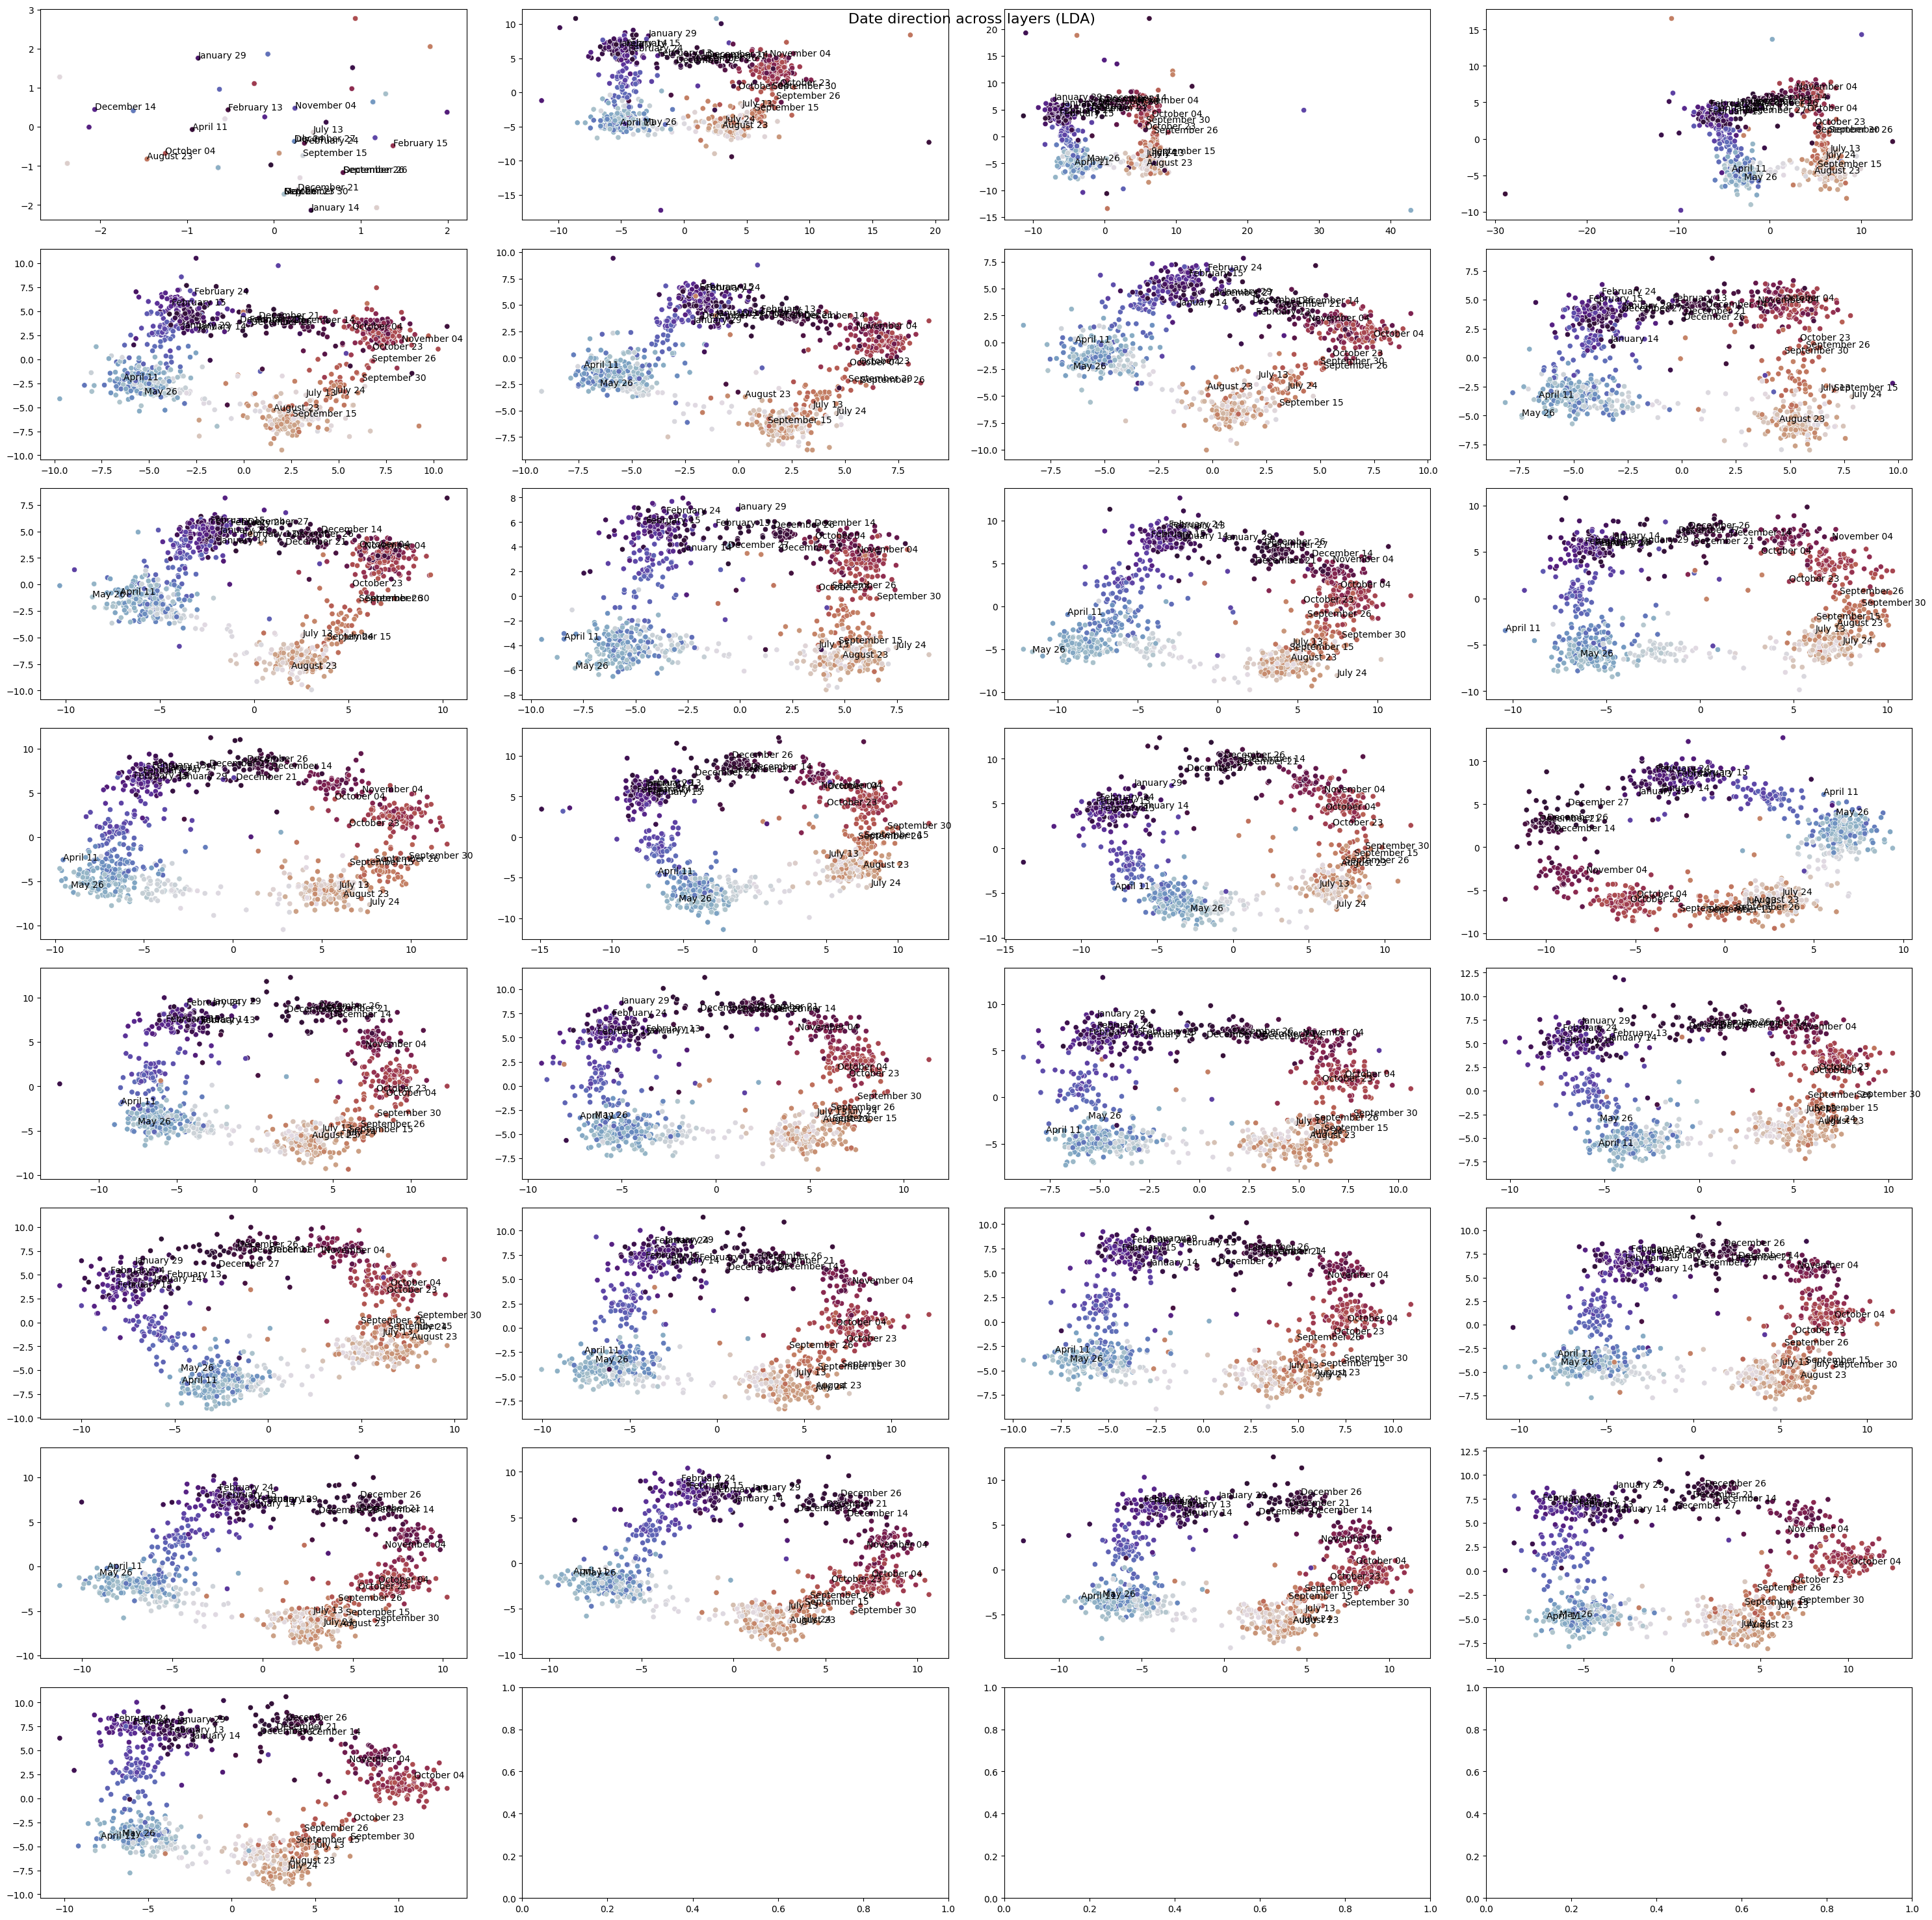

In [5]:
# LDA with a discrete label on all layers

component1 = 0
component2 = 1

if 'correct_date' in test_set.columns:
    discrete_labels_train = train_set['correct_date'].apply(lambda x: x.month)
    discrete_labels_test = test_set['correct_date'].apply(lambda x: x.month)
elif 'correct_time' in test_set.columns:
    discrete_labels_train = train_set['correct_time'].apply(lambda x: x.hour)
    discrete_labels_test = test_set['correct_time'].apply(lambda x: x.hour)
    # discrete_labels_train = pd.to_datetime(train_set['time']).apply(lambda x: x.hour)
    # discrete_labels_test = pd.to_datetime(test_set['time']).apply(lambda x: x.hour)

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 20)

for i, layer in enumerate(activations_train):
    nm = Normalizer()
    nm.fit(layer)

    norm_train = nm.transform(layer)
    norm_dev = nm.transform(activations_dev[i])
    norm_test = nm.transform(activations_test[i])

    # Fit LDA using train set and train labels
    lda = LDA(n_components=2)
    lda.fit(norm_train, discrete_labels_train)

    # Transform test set
    transformed_test = lda.transform(norm_test)

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)
    elif 'correct_time' in test_set.columns:
        # rnd_sent = test_set.iloc[indices].apply(lambda x: format_time(x['correct_time']), axis=1)
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%H:%M'), axis=1)
        # rnd_sent = pd.to_datetime(test_set['time']).iloc[indices].apply(lambda x: x.strftime('%H:%M'))

# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    sns.scatterplot(x=transformed_test_list[i][:, component1],
                    y=transformed_test_list[i][:, component2],
                    hue=labels_test, ax=ax, palette='twilight_shifted')
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        # Text must have a white outline
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))
                        # fontsize=12, color='white', weight='bold',
                        # bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3'))

plt.suptitle('Date direction across layers (LDA)', fontsize=16)
plt.tight_layout()
plt.show()


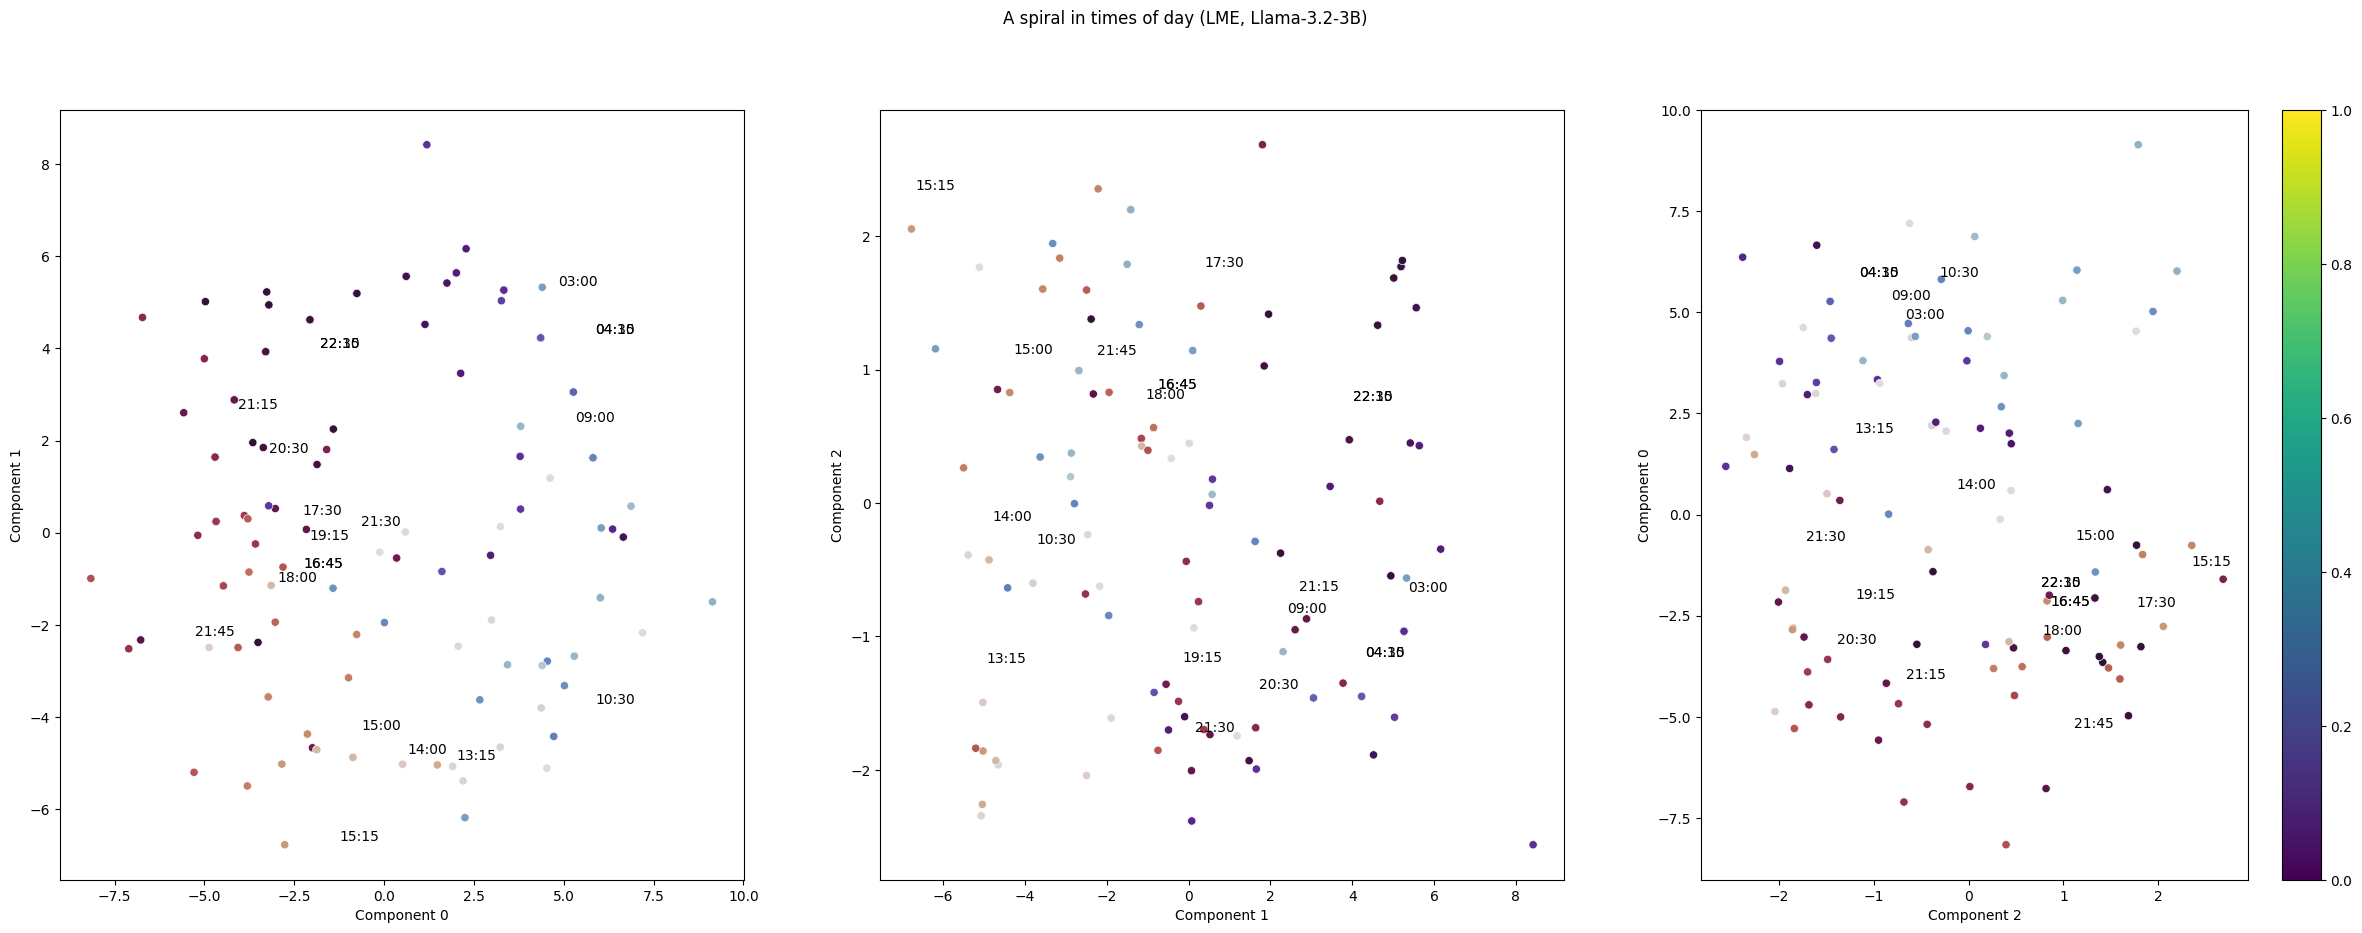

In [25]:
# LME (LinearMetricEmbedder) with discrete label

best_layer = 7

if 'correct_date' in test_set.columns:
    discrete_labels_train = train_set['correct_date'].apply(lambda x: x.month).to_numpy()
    discrete_labels_test = test_set['correct_date'].apply(lambda x: x.month).to_numpy()
elif 'correct_time' in test_set.columns:
    discrete_labels_train = train_set['correct_time'].apply(lambda x: x.hour).to_numpy()
    discrete_labels_test = test_set['correct_time'].apply(lambda x: x.hour).to_numpy()

lme = LinearMetricEmbedder(n_components=3, graph='circular')
lme.fit(activations_train[best_layer], discrete_labels_train)


lme_test = lme.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(activations_test[best_layer]), 20)
# Get sentences and acivations
if 'sentence' in test_set.columns:
    rnd_sent = test_set['sentence'].iloc[indices]
elif 'correct_date' in test_set.columns:
    rnd_sent = test_set['correct_date'].iloc[indices]
    # Parse as month day
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%B %d')
elif 'correct_time' in test_set.columns:
    rnd_sent = test_set['correct_time'].iloc[indices]
    # Parse as hour minute
    rnd_sent = pd.to_datetime(rnd_sent).dt.strftime('%H:%M')
rnd_activations = activations_test[best_layer][indices]
# Transform activations
rnd_activations = lme.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    # sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=lme_test[:, i%3], y=lme_test[:, (i+1)%3], hue=labels_test, ax=ax, palette='twilight_shifted')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('A spiral in times of day (LME, Llama-3.2-3B)')
plt.show()


In [ ]:
# Isomap with a continuous label on all layers

component1 = 0
component2 = 1

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 7)

for i, layer in enumerate(activations_train):
    nm = Normalizer()
    nm.fit(layer)

    norm_train = nm.transform(layer)
    norm_dev = nm.transform(activations_dev[i])

    # Apply Isomap to normalized test data
    norm_test = nm.transform(activations_test[i])
    isomap = Isomap(n_components=2, n_neighbors=30)
    transformed_test = isomap.fit_transform(norm_test)

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    if 'correct_date' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)
    elif 'correct_time' in test_set.columns:
        rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_time'].strftime('%H:%M'), axis=1)

# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    sns.scatterplot(x=transformed_test_list[i][:, component1],
                    y=transformed_test_list[i][:, component2],
                    hue=labels_test, ax=ax, palette='viridis')
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))

plt.suptitle('Date direction across layers (Isomap)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# TSNE with a continuous label on all layers
component1 = 0
component2 = 1

transformed_test_list = []
rnd_activations = []

# Generate 7 random indices
indices = np.random.choice(len(activations_test[0]), 7)

for i, layer in enumerate(activations_train):
    nm = Normalizer()
    nm.fit(layer)

    norm_train = nm.transform(layer)
    norm_dev = nm.transform(activations_dev[i])

    # Now apply t-SNE to test data for visualization
    norm_test = nm.transform(activations_test[i])
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
    transformed_test = tsne.fit_transform(norm_test)

    transformed_test_list.append(transformed_test)
    rnd_activations.append(transformed_test[indices])

    rnd_sent = test_set.iloc[indices].apply(lambda x: x['correct_date'].strftime('%B %d'), axis=1)


# Plotting
fig, axs = plt.subplots(int(np.ceil(len(transformed_test_list)/4)), 4, figsize=(30, 30))

for i in range(len(transformed_test_list)):
    ax = axs[i//4][i%4]
    sns.scatterplot(x=transformed_test_list[i][:, component1],
                    y=transformed_test_list[i][:, component2],
                    hue=labels_test, ax=ax, palette='viridis')
    ax.get_legend().set_visible(False)

    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[i][j, component1], rnd_activations[i][j, component2]))

plt.suptitle('Date direction across layers (t-SNE)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# PCA with discrete classes

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    pca = PCA(n_components=2)
    pca.fit(layer)
    transformed_train = pca.transform(layer)
    transformed_dev = pca.transform(activations_test[i])
    score = np.corrcoef(transformed_dev[:, 0], test_set['label'])[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 6 # Override best layer

pca = PCA(n_components=3)
pca.fit(activations_train[best_layer])
pca_all = pca.transform(all_activations[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 20)
# Get sentences and activations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
classes = df['class'].unique()
palette = {classes[i]: sns.color_palette()[i] for i in range(len(classes))}
print(palette)
for i, ax in enumerate(axs):
    sns.scatterplot(x=pca_all[:, i % 3], y=pca_all[:, (i + 1) % 3], hue=all_classes, ax=ax, palette=palette)
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')

# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

In [ ]:
# PCA with a continuous label and evaluation on verbs - Doesnt work

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    pca = PCA(n_components=2)
    pca.fit(layer)
    transformed_train = pca.transform(layer)
    transformed_dev = pca.transform(activations_test[i])
    score = np.corrcoef(transformed_dev[:, 0], test_set['label'])[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 18 # Override best layer

pca = PCA(n_components=3)
pca.fit(activations_train[best_layer])
pca_all = pca.transform(all_activations[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 20)
# Get sentences and activations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pca_all[:, i % 3], y=pca_all[:, (i + 1) % 3], hue=all_labels, ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')
    ax.get_legend().set_visible(False)

fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

In [ ]:
# PLS regression with two classes

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=2)
    pls.fit(layer, train_set['label'])
    score = pls.score(activations_test[i], test_set['label'])
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 10 # Override best layer


pls = PLSRegression(n_components=3)
pls.fit(activations_train[best_layer], train_set['label'])

pls_train = pls.transform(activations_train[best_layer])
pls_test = pls.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 10)
# Get sentences and acivations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pls.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pls_test[:, i%3], y=pls_test[:, (i+1)%3], hue=test_set['label'], ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for gemma-2-2b')
plt.show()

### Extra stuff

In [ ]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoModel, AutoTokenizer, GPT2Config
import torch
import transformers
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import datetime
from tqdm import tqdm

model = AutoModel.from_pretrained("gpt2", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model.to("cuda")

text = "I am very happy to see you."
input_ids = tokenizer(text, return_tensors="pt").to("cuda")

for i in range(1,len(input_ids['input_ids'][0])):
    inputs = input_ids['input_ids'][:,:i]
    inputs = {'input_ids': inputs}
    generations = model(**inputs, output_hidden_states=True)
    hidden_states = generations.hidden_states
    print(f"Hidden states: {hidden_states[-1][0,0,:10]}")

Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden states: tensor([-0.0796, -0.0654, -0.0842, -0.0337, -0.0758, -0.2051, -0.4378, -0.1028,
        -0.1290,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
Hidden sta

In [ ]:
transformers.set_seed(11)

abs_rel_set = df[df['specificity'] != 'anchored']
anch_set = df[df['specificity'] == 'anchored']
# Create train and test sets
train_set = abs_rel_set.sample(frac=0.8)
test_set = abs_rel_set.drop(train_set.index)
train_labels = pd.get_dummies(train_set['specificity'])['absolute']
test_labels = pd.get_dummies(test_set['specificity'])['absolute']

print(train_set.iloc[0])

activations_train = compute_activations(train_set)
activations_test = compute_activations(test_set)
activations_anch = compute_activations(anch_set)

all_activations = np.concatenate([activations_train, activations_test, activations_anch], axis=1)
all_labels = df['specificity']

ss = StandardScaler()
ss.fit(activations_train)

best_layer = 6 # Override best layer


pca = PCA(n_components=3)

pca.fit(ss.transform(activations_train[best_layer]))

pls_all = pca.transform(ss.transform(all_activations[best_layer]))
# plt.figure(figsize=(8, 8))
# sns.scatterplot(x=pls_output[:, 0], y=pls_output[:, 1], hue=df['specificity'], palette='viridis')
# sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels)
# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels, ax=axs[0])
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 2], hue=all_labels, ax=axs[1])
sns.scatterplot(x=pls_all[:, 1], y=pls_all[:, 2], hue=all_labels, ax=axs[2])
plt.show()

# pca = PCA(n_components=3)
# pca.fit(layer4_outputs)
# pca_output = pca.transform(layer4_outputs)
# # Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
# fig, axs = plt.subplots(1, 3, figsize=(30, 10))
# sns.scatterplot(x=pca_output[:, 0], y=pca_output[:, 1], hue=labels, palette='viridis', ax=axs[0])
# sns.scatterplot(x=pca_output[:, 0], y=pca_output[:, 2], hue=labels, palette='viridis', ax=axs[1])
# sns.scatterplot(x=pca_output[:, 1], y=pca_output[:, 2], hue=labels, palette='viridis', ax=axs[2])
# plt.show()

In [ ]:
transformers.set_seed(11)

abs_rel_set = df[df['specificity'] != 'anchored']
anch_set = df[df['specificity'] == 'anchored']
# Create train and test sets
train_set = abs_rel_set.sample(frac=0.8)
test_set = abs_rel_set.drop(train_set.index)
train_labels = pd.get_dummies(train_set['specificity'])['absolute']
test_labels = pd.get_dummies(test_set['specificity'])['absolute']

print(train_set.iloc[0])

activations_train = compute_activations(train_set)
activations_test = compute_activations(test_set)
activations_anch = compute_activations(anch_set)

all_activations = np.concatenate([activations_train, activations_test, activations_anch], axis=1)
all_labels = df['specificity']

print(activations_train[0,0,:5])

print(activations_train.shape)
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    pls = PLSRegression(n_components=2)
    pls.fit(layer, train_labels)
    score = pls.score(activations_test[i], test_labels)
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 6 # Override best layer


pls = PLSRegression(n_components=2)
pls.fit(activations_train[best_layer], train_labels)

pls_all = pls.transform(all_activations[best_layer])
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=pls_output[:, 0], y=pls_output[:, 1], hue=df['specificity'], palette='viridis')
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels)

plt.title('Latent space directions found by PLS')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()